<a href="https://colab.research.google.com/github/Coconut3223/Federated-learning/blob/main/Task3_FL4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Config:

In [ ]:
#@title import Necessary package 
import copy
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


In [ ]:
#@title Google drive 
#read data from Google drive
from google.colab import drive
import os
import pandas as pd
drive.mount('/content/drive', force_remount=True)
os.chdir("/content/drive/My Drive/COMP5434_Proj")
!ls

Mounted at /content/drive
Task3_FL4.ipynb  Train_Data_ConvertedDropped1.csv


In [ ]:
#@title  Model: MLP ( same as Task2
class MLP(nn.Module):
    def __init__(self):
        super(MLP,self).__init__()
        self.module = torch.nn.Sequential(
            torch.nn.Linear(10, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 4),
        )
    def forward(self, x):
        x =  self.module(x)
        return x

In [ ]:
#@title config
dataset_path = "./Train_Data_ConvertedDropped1.csv"
test_path = None
user_num = 4
alpha = None
batch_size = 50
global_rounds = 60
local_epochs = 30

# Load dataset

In [ ]:
#@title feature process ( same as Task2
def feature_process(X):
    """
    :param X: features need to be StandardScaler
    :return : (format: 
    """
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    return X
def label_process(y):
    """
    : param y: total cost 
    : return : cost level (format: 
    """
    bins = [0, 300000, 500000, 700000, np.inf]
    labels = [0, 2, 2, 3]
    y = pd.cut(y, bins=bins, labels=labels)
    y = np.array(y)
    return y


In [ ]:
#@title transform data into dataset which can be further transformed into dataloader
class toDataset(Dataset):
    """
    :param Dataset: [X,y] (np.array
    :return: (torch.dataset
    """
    def __init__(self, features, labels):
        self.features = torch.from_numpy(features)
        self.labels = torch.from_numpy(labels)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        return self.features[index], self.labels[index]

class DatasetSplit(Dataset):
    """
    help simulate different distributions, IID, Non-IID 
    :param Dataset: the whole dataset
    :return: the whole dataset and indices of whole dataset which are assigned to the sub-dataset
    """

    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = [int(i) for i in idxs]

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        features, labels = self.dataset[self.idxs[item]]
        return torch.tensor(features), torch.tensor(labels)
    
    def getlabels(self):
        labels = []
        for item in range(len(self)):
            labels.append(self.dataset[self.idxs[item]][1].item())
        return labels

In [ ]:
#@title Load data
def Load_data(dataset_path):
    """
    :param path: (csv
    :return: train dataset and test dataset (format: torch.dataset
    :Setting: sf=features, train:test=9:1, valid<=>test
    """
    dataset = pd.read_csv(dataset_path)
    sf = ['number of rooms', 'security level of the community', 'residence space', 'building space', 'noise level', 'view','aboveground space ', 'basement space', 'LAT', "building year"]
    X,y = feature_process(dataset[sf].values), label_process(dataset['total cost'].values)


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)
    dataset = toDataset(X, y)

    train_dataset = toDataset(X_train, y_train)
    test_dataset = toDataset(X_test, y_test)

    return train_dataset, test_dataset

# Simulate different distributions

In [ ]:
#@title using dirichlet_distributiom

def dirichlet_partition(training_data, testing_data, alpha, user_num):
    """
    :param traning/testing_data: the whole datasert (torch.dataset
    :param alpha: 0.5 non-iid 1000 ~ iid simulate iid by modifying alpha
    """
    idxs_train = np.arange(len(training_data))
    idxs_valid = np.arange(len(testing_data))
    labels_train = training_data.labels
    labels_valid = testing_data.labels

    idxs_labels_train = np.vstack((idxs_train, labels_train))
    idxs_labels_train = idxs_labels_train[:, idxs_labels_train[1,:].argsort()]
    idxs_labels_valid = np.vstack((idxs_valid, labels_valid))
    idxs_labels_valid = idxs_labels_valid[:, idxs_labels_valid[1,:].argsort()]

    labels = np.unique(labels_train, axis=0)

    data_train_dict = data_organize(idxs_labels_train, labels)
    data_valid_dict = data_organize(idxs_labels_valid, labels)

    data_partition_profile_train = {}
    data_partition_profile_valid = {}


    for i in range(user_num):
        data_partition_profile_train[i] = []
        data_partition_profile_valid[i] = []

    ## Distribute rest data
    for label in data_train_dict:
        proportions = np.random.dirichlet(np.repeat(alpha, user_num))
        proportions_train = len(data_train_dict[label])*proportions
        proportions_valid = len(data_valid_dict[label]) * proportions

        for user in data_partition_profile_train:

            data_partition_profile_train[user]   \
                = set.union(set(np.random.choice(data_train_dict[label], int(proportions_train[user]) , replace = False)), data_partition_profile_train[user])
            data_train_dict[label] = list(set(data_train_dict[label])-data_partition_profile_train[user])


            data_partition_profile_valid[user] = set.union(set(
                np.random.choice(data_valid_dict[label], int(proportions_valid[user]),
                                 replace=False)), data_partition_profile_valid[user])
            data_valid_dict[label] = list(set(data_valid_dict[label]) - data_partition_profile_valid[user])


        while len(data_train_dict[label]) != 0:
            rest_data = data_train_dict[label][0]
            user = np.random.randint(0, user_num)
            data_partition_profile_train[user].add(rest_data)
            data_train_dict[label].remove(rest_data)

        while len(data_valid_dict[label]) != 0:
            rest_data = data_valid_dict[label][0]
            user = np.random.randint(0, user_num)
            data_partition_profile_valid[user].add(rest_data)
            data_valid_dict[label].remove(rest_data)

    for user in data_partition_profile_train:
        data_partition_profile_train[user] = list(data_partition_profile_train[user])
        data_partition_profile_valid[user] = list(data_partition_profile_valid[user])
        np.random.shuffle(data_partition_profile_train[user])
        np.random.shuffle(data_partition_profile_valid[user])

    return data_partition_profile_train, data_partition_profile_valid


def data_organize(idxs_labels, labels):
    data_dict = {}

    labels = np.unique(labels, axis=0)
    for one in labels:
        data_dict[one] = []

    for i in range(len(idxs_labels[1, :])):
        data_dict[idxs_labels[1, i]].append(idxs_labels[0, i])
    return data_dict


In [ ]:
#@title check_Distribution using bar plot

def checkDistribution(train_data_list):
    """
    :param train_data_list: [#client, torch.dataset]
    """
    users = []
    for user_index in train_data_list:
        labels = user_index.getlabels()
        label_count_dict = dict(pd.value_counts(labels))
        label_count_list=[]
        for i in range(4):
            label_count_list.append(label_count_dict[i])
            print(label_count_list)
        users.append(label_count_list)
        print("users:",users)
    labels = ["client_0","client_1","client_2","client_3"]
    x = range(len(labels))
    width = 0.35
    legend = []

    bottom_y = np.zeros(len(labels))
    data = np.array(users)
    plt.figure(figsize=(5,5))
    sums = np.sum(data, axis=0) 
    for i in range(len(data)):
        y = data[i] / sums
        plt.bar(x, y, width, bottom=bottom_y)
        bottom_y = y + bottom_y
    
    legend=plt.legend(title='Cost Level',labels=[1,2,3,4], fontsize=16, loc='upper right', bbox_to_anchor=(1.4, 0.8),frameon=False)
    plt.xticks(x, labels,fontsize=16)
    legend.get_title().set_fontsize('17')
    plt.ylabel("percentage",fontsize=16)
    plt.title('Distribution of data of Clients ',fontsize=20)
    plt.show()


# FL architecture

In [ ]:
#@title Local Training function
def local_trainer(dataset, model, device, local_epoch, batchsize):
    """
    :target: finish all local training in each global around
    :param dataset: local dataset of each client
    :param model: global model
    :param device: gpu
    :param local epoch: set in config
    :param batchsize:  set in config
    :return model.state_dict(): updated client's local model's parameters packed in dic
    :return loss: epoch loss
    """
    dataloader = DataLoader(dataset, batch_size=batchsize, shuffle=True)
    criterion = nn.CrossEntropyLoss().to(device)
    model.train()
    epoch_loss = []
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9,0.999), eps=1e-08, weight_decay=0)
    for iter in range(local_epoch):
        batch_loss = []
        for batch_idx, (features, labels) in enumerate(dataloader):
            features, labels = features.type(torch.FloatTensor).to(device), labels.to(device)
            model.zero_grad()
            logits = model(features)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            batch_loss.append(loss.item())
            
        epoch_loss.append(sum(batch_loss)/len(batch_loss))
       
    return model.state_dict(), sum(epoch_loss) / len(epoch_loss)

In [ ]:
def inference(model, testloader):
    """ 
    :target: test the accuracy on validation dataset after every global communication
    :param model: global model
    :return  accuracy, loss: 
    """
    model.eval()
    criterion = nn.CrossEntropyLoss().to(device)
    loss, total, correct = 0.0, 0.0, 0.0
    for batch_idx, (features, labels) in enumerate(testloader):
        features, labels = features.type(torch.FloatTensor).to(device), labels.to(device)
        # Inference
        outputs = model(features)
        batch_loss = criterion(outputs, labels)
        loss += batch_loss.item()

        # Prediction
        _, pred_labels = torch.max(outputs, 1)
        pred_labels = pred_labels.view(-1)
        correct += torch.sum(torch.eq(pred_labels, labels)).item()
        total += len(labels)
    loss /= batch_idx
    accuracy = correct/total
    return accuracy, loss

## different aggregation strategies

In [ ]:
#@title Avg
def average_weights(w):
    """
    :param w: all local parameters [4, parameter]
    :return w_avg: new global parameters after aggregation
    """
    w_avg = copy.deepcopy(w[0])
    for key in w_avg.keys():
        for i in range(1, len(w)):
            w_avg[key] += w[i][key]
        w_avg[key] = torch.div(w_avg[key].float(), len(w))
    return w_avg

In [ ]:
#@title Weighted Avg depending on #data each client has
def weighted_average_weights(w, proportion):
    """
    :param w: all local parameters [4, parameter]
    :param proprtion: proportion of each client which sum= 1, [4]
    :return w_avg: new global parameters after aggregation
    """
    w_wavg = copy.deepcopy(w[0]) 

    for key in w_wavg.keys():
        w_wavg[key] = 0
        for i in range(0, len(w)):
            w_wavg[key] += w[i][key].float() * proportion[i]
    return w_wavg

# __Main__

## IID

In [ ]:
alpha = 1000

[202]
[202, 339]
[202, 339, 217]
[202, 339, 217, 167]
users: [[202, 339, 217, 167]]
[195]
[195, 336]
[195, 336, 199]
[195, 336, 199, 174]
users: [[202, 339, 217, 167], [195, 336, 199, 174]]
[196]
[196, 329]
[196, 329, 207]
[196, 329, 207, 161]
users: [[202, 339, 217, 167], [195, 336, 199, 174], [196, 329, 207, 161]]
[184]
[184, 325]
[184, 325, 205]
[184, 325, 205, 164]
users: [[202, 339, 217, 167], [195, 336, 199, 174], [196, 329, 207, 161], [184, 325, 205, 164]]


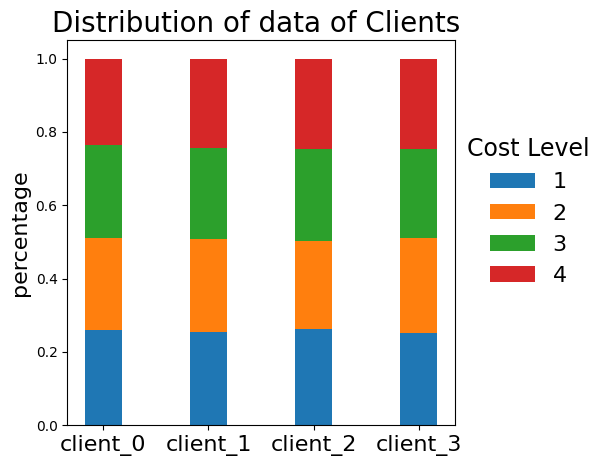

In [ ]:
""" load and split data  """
train_dataset, test_dataset = Load_data(dataset_path)
train_index, test_index = dirichlet_partition(train_dataset, test_dataset, alpha=alpha, user_num=user_num)

""" divide dataset to clients"""
train_data_list = []
for user_index in range(user_num):
    train_data_list.append(DatasetSplit(train_dataset, train_index[user_index]))
checkDistribution(train_data_list)

In [ ]:
#@title global training

""" train and test"""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
IID_global_model = MLP().to(device)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
IID_accu =[]
IID_loss =[]
for round_idx in range(global_rounds):
    local_weights = []
    local_losses = []
    global_acc = []

    for user_index in range(user_num):
        model_weights, loss1 = local_trainer(train_data_list[user_index], copy.deepcopy(IID_global_model), device, local_epochs, batch_size)
        local_weights.append(copy.deepcopy(model_weights))
        local_losses.append(loss1)

    global_weight = average_weights(local_weights)
    IID_global_model.load_state_dict(global_weight)
    test_acc, test_loss = inference(IID_global_model, test_loader)
    IID_accu.append(test_acc)
    IID_loss.append(test_loss)
    print('Global Round :{}, the global accuracy is {:.3}%, and the global loss is {:.3}.'.format(round_idx, 100 * test_acc, test_loss))

<ipython-input-7-46581b821845>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(features), torch.tensor(labels)


Global Round :0, the global accuracy is 52.8%, and the global loss is 1.19.
Global Round :1, the global accuracy is 60.0%, and the global loss is 1.0.
Global Round :2, the global accuracy is 62.7%, and the global loss is 0.94.
Global Round :3, the global accuracy is 64.2%, and the global loss is 0.911.
Global Round :4, the global accuracy is 65.2%, and the global loss is 0.891.
Global Round :5, the global accuracy is 67.2%, and the global loss is 0.874.
Global Round :6, the global accuracy is 68.2%, and the global loss is 0.862.
Global Round :7, the global accuracy is 68.5%, and the global loss is 0.851.
Global Round :8, the global accuracy is 69.8%, and the global loss is 0.842.
Global Round :9, the global accuracy is 70.2%, and the global loss is 0.835.
Global Round :10, the global accuracy is 70.0%, and the global loss is 0.829.
Global Round :11, the global accuracy is 70.5%, and the global loss is 0.823.
Global Round :12, the global accuracy is 70.8%, and the global loss is 0.818.


In [ ]:
#@title predict test_dataset
from numpy import argmax
test_path = "./Test_Data_Converted&Dropped.csv"

test_dataset_csv = pd.read_csv(test_path)
sf = ['number of rooms', 'security level of the community', 'residence space', 'building space', 'noise level', 'view','aboveground space ', 'basement space', 'LAT', "building year"]
test_X = feature_process(test_dataset_csv[sf].values)

test_dataset = toDataset(test_X, np.array([]*len(test_dataset)))
test_features = test_dataset.features.type(torch.FloatTensor).to(device)
outputs = [argmax(p.detach().numpy())+1 for p in IID_global_model(test_features)]
print(len(outputs),outputs[:5])
test_dataset_csv["total cost"] = outputs
test_dataset_csv.to_csv("./Test_Data_Task3.csv")


[[ 0.8977427   0.51338996  0.71284242 -0.44267423 -0.05037663 -0.49760208
   0.21186595  1.40907045  0.50448927 -1.15235401]
 [-0.95805616 -1.01531463 -0.89824688 -0.33194387 -0.96631537 -0.49760208
  -0.87329753 -0.56397981  0.65168037 -0.15068034]
 [-0.95805616 -1.01531463 -0.83745106 -0.13262924 -0.96631537 -0.49760208
  -0.79508755 -0.56397981  1.00149443 -0.32239583]
 [ 1.82564213  0.51338996  1.26760431  0.21519435  0.86556211  2.93413641
   1.63919809 -0.01699558  0.09778411 -0.80892304]
 [-0.95805616 -1.01531463 -0.82225211 -0.31240322 -0.96631537 -0.49760208
  -0.77553505 -0.56397981  1.04018345 -0.15068034]]
400 [4, 2, 2, 4, 2]


## Non-IID

In [ ]:
alpha = 0.5

[73]
[73, 15]
[73, 15, 247]
[73, 15, 247, 34]
users: [[73, 15, 247, 34]]
[352]
[352, 837]
[352, 837, 470]
[352, 837, 470, 91]
users: [[73, 15, 247, 34], [352, 837, 470, 91]]
[73]
[73, 421]
[73, 421, 3]
[73, 421, 3, 52]
users: [[73, 15, 247, 34], [352, 837, 470, 91], [73, 421, 3, 52]]
[279]
[279, 56]
[279, 56, 108]
[279, 56, 108, 489]
users: [[73, 15, 247, 34], [352, 837, 470, 91], [73, 421, 3, 52], [279, 56, 108, 489]]


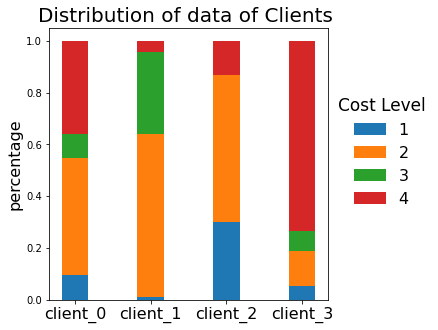

In [ ]:
""" load and split data  """
train_dataset, test_dataset = Load_data(dataset_path)
train_index, test_index = dirichlet_partition(train_dataset, test_dataset, alpha=alpha, user_num=user_num)

""" divide dataset to clients"""
train_data_list = []
for user_index in range(user_num):
    train_data_list.append(DatasetSplit(train_dataset, train_index[user_index]))
checkDistribution(train_data_list)

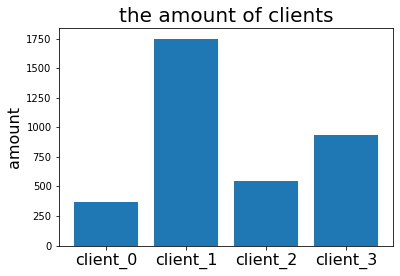

In [ ]:
y=[]
for i in range(4):
    y.append(len(train_data_list[i]))
x=[1,2,3,4]
labels = ["client_0","client_1","client_2","client_3"]
plt.bar(x,y)
plt.xticks(x, labels,fontsize=16)
plt.ylabel("amount",fontsize=16)
plt.title("the amount of clients",fontsize=20)
plt.show()

In [ ]:
#@title global training with FedAvg

""" train and test"""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
global_model = MLP().to(device)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
NIID_accu =[]
NIID_loss =[]
for round_idx in range(global_rounds):
    local_weights = []
    local_losses = []
    global_acc = []

    for user_index in range(user_num):
        model_weights, loss1 = local_trainer(train_data_list[user_index], copy.deepcopy(global_model), device, local_epochs, batch_size)
        local_weights.append(copy.deepcopy(model_weights))
        local_losses.append(loss1)

    global_weight = average_weights(local_weights)
    global_model.load_state_dict(global_weight)
    test_acc, test_loss = inference(global_model, test_loader)
    NIID_accu.append(test_acc)
    NIID_loss.append(test_loss)
    print('Global Round :{}, the global accuracy is {:.3}%, and the global loss is {:.3}.'.format(round_idx, 100 * test_acc, test_loss))

<ipython-input-54-46581b821845>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(features), torch.tensor(labels)


Global Round :0, the global accuracy is 58.8%, and the global loss is 1.3.
Global Round :1, the global accuracy is 59.0%, and the global loss is 1.09.
Global Round :2, the global accuracy is 61.0%, and the global loss is 1.01.
Global Round :3, the global accuracy is 62.0%, and the global loss is 0.964.
Global Round :4, the global accuracy is 62.7%, and the global loss is 0.937.
Global Round :5, the global accuracy is 63.7%, and the global loss is 0.919.
Global Round :6, the global accuracy is 65.2%, and the global loss is 0.905.
Global Round :7, the global accuracy is 65.5%, and the global loss is 0.893.
Global Round :8, the global accuracy is 66.0%, and the global loss is 0.883.
Global Round :9, the global accuracy is 66.2%, and the global loss is 0.875.
Global Round :10, the global accuracy is 66.8%, and the global loss is 0.868.
Global Round :11, the global accuracy is 67.5%, and the global loss is 0.86.
Global Round :12, the global accuracy is 68.0%, and the global loss is 0.856.
G

In [ ]:
#@title global training with Weighted_Avg

""" train and test"""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
global_model = MLP().to(device)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
NIID_w_accu =[]
NIID_w_loss =[]
for round_idx in range(global_rounds):
    local_weights = []
    local_losses = []
    global_acc = []

    for user_index in range(user_num):
        model_weights, loss1 = local_trainer(train_data_list[user_index], copy.deepcopy(global_model), device, local_epochs, batch_size)
        local_weights.append(copy.deepcopy(model_weights))
        local_losses.append(loss1)

    global_weight = average_weights(local_weights)
    global_model.load_state_dict(global_weight)
    test_acc, test_loss = inference(global_model, test_loader)
    NIID_w_accu.append(test_acc)
    NIID_w_loss.append(test_loss)
    print('Global Round :{}, the global accuracy is {:.3}%, and the global loss is {:.3}.'.format(round_idx, 100 * test_acc, test_loss))

<ipython-input-54-46581b821845>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(features), torch.tensor(labels)


Global Round :0, the global accuracy is 51.2%, and the global loss is 1.29.
Global Round :1, the global accuracy is 54.2%, and the global loss is 1.11.
Global Round :2, the global accuracy is 59.0%, and the global loss is 1.03.
Global Round :3, the global accuracy is 60.2%, and the global loss is 0.987.
Global Round :4, the global accuracy is 61.3%, and the global loss is 0.963.
Global Round :5, the global accuracy is 62.3%, and the global loss is 0.946.
Global Round :6, the global accuracy is 63.2%, and the global loss is 0.931.
Global Round :7, the global accuracy is 64.0%, and the global loss is 0.921.
Global Round :8, the global accuracy is 64.5%, and the global loss is 0.912.
Global Round :9, the global accuracy is 64.5%, and the global loss is 0.902.
Global Round :10, the global accuracy is 65.2%, and the global loss is 0.896.
Global Round :11, the global accuracy is 65.8%, and the global loss is 0.889.
Global Round :12, the global accuracy is 66.5%, and the global loss is 0.883.

## Comparision

In [ ]:
import matplotlib.pyplot as plt
def plot(opti_name,epoch, loss, acc):
    plt.figure(figsize=(10,10)) #放大
    x = range(epoch)
    loss_train = loss
    acc_train = acc
    plt.subplot(2,1,1)
    plt.plot(x,loss_train, color = "r")
    plt.title(opti_name + " LOSS vs. epoches")
    
    plt.ylabel("LOSS")
    plt.subplot(2,1,2)
    plt.plot(x,acc_train, color = "r")
  
    plt.ylabel("ACCURACY")
    plt.xlabel("Epoches")
    plt.xlabel(opti_name + " ACCURACY vs. epoches")
    plt.show()

In [ ]:
print(IID_accu)

[0.565, 0.5975, 0.635, 0.6425, 0.665, 0.6675, 0.6725, 0.68, 0.6875, 0.6975, 0.6975, 0.6975, 0.71, 0.715, 0.72, 0.7225, 0.7225, 0.73, 0.73, 0.73, 0.7375, 0.735, 0.735, 0.7325, 0.7325, 0.7325, 0.7425, 0.74, 0.74, 0.7425, 0.74, 0.74, 0.745, 0.755, 0.755, 0.755, 0.755, 0.7575, 0.7575, 0.755, 0.755, 0.755, 0.7525, 0.7525, 0.755, 0.7525, 0.755, 0.755, 0.755, 0.755, 0.755, 0.755, 0.7525, 0.75, 0.7525, 0.75, 0.75, 0.7475, 0.75, 0.7475]


In [ ]:
print(IID_loss)

[1.1738750083105904, 0.9957910776138306, 0.9431542924472264, 0.91587552853993, 0.8961282883371625, 0.8796472208840507, 0.8658587847437177, 0.8535975132669721, 0.8437025887625558, 0.8344865781920296, 0.8271403993879046, 0.8199013045855931, 0.8132927247456142, 0.8080423474311829, 0.8035490342548915, 0.7991575769015721, 0.7959823438099453, 0.7929044876779828, 0.7901022604533604, 0.787697800568172, 0.7858852403504508, 0.7841957254069192, 0.7830357040677752, 0.7813507233347211, 0.7798463702201843, 0.7785587055342538, 0.7776468183313098, 0.7764815645558494, 0.7750065156391689, 0.7739401629992894, 0.7726472360747201, 0.7721651877675738, 0.7714317951883588, 0.7706241607666016, 0.7703351719038827, 0.7699057034083775, 0.7694466241768428, 0.7687724913869586, 0.7688637886728559, 0.7687074371746608, 0.7686740585735866, 0.7684046030044556, 0.7686518430709839, 0.7679504070963178, 0.7689285022871835, 0.7686744715486254, 0.7691985496452877, 0.7691837293761117, 0.7699343945298877, 0.7708449363708496, 0.

In [ ]:
print(NIID_accu)

[0.5875, 0.59, 0.61, 0.62, 0.6275, 0.6375, 0.6525, 0.655, 0.66, 0.6625, 0.6675, 0.675, 0.68, 0.695, 0.69, 0.6975, 0.7, 0.71, 0.705, 0.7025, 0.7075, 0.71, 0.7075, 0.71, 0.7125, 0.715, 0.71, 0.71, 0.705, 0.7025, 0.7075, 0.7125, 0.71, 0.715, 0.7125, 0.705, 0.705, 0.71, 0.7125, 0.715, 0.7125, 0.7125, 0.7125, 0.7125, 0.7125, 0.71, 0.7075, 0.7075, 0.7075, 0.705, 0.7, 0.7025, 0.705, 0.7075, 0.705, 0.7075, 0.705, 0.7075, 0.7025, 0.705]


In [ ]:
print(NIID_loss)

[1.298877273287092, 1.0930751391819544, 1.0060127462659563, 0.9639158419200352, 0.9369514584541321, 0.9190299425806318, 0.9052702784538269, 0.8931384597505841, 0.8827519416809082, 0.8748129946844918, 0.8681637048721313, 0.8600503206253052, 0.8559356416974749, 0.8514219863074166, 0.847216044153486, 0.8440960390227181, 0.8407577701977321, 0.8383337003844125, 0.8365858452660697, 0.8344288298061916, 0.8335581507001605, 0.8330267838069371, 0.8317688192640033, 0.8318059870174953, 0.8291051387786865, 0.8298518061637878, 0.8275550774165562, 0.8283267787524632, 0.8279749921389988, 0.8284923604556492, 0.8277223706245422, 0.8273940767560687, 0.8276848452431815, 0.8267627358436584, 0.8278939894267491, 0.8281601667404175, 0.8276326315743583, 0.8269274319921222, 0.829441521848951, 0.8287016493933541, 0.8272319861820766, 0.8303524426051548, 0.8292907135827201, 0.8291663868086678, 0.8296842404774257, 0.8298512271472386, 0.8298783302307129, 0.8296949522835868, 0.8313665475164141, 0.8308633055005755, 0.

In [ ]:
print(NIID_w_accu)

[0.5125, 0.5425, 0.59, 0.6025, 0.6125, 0.6225, 0.6325, 0.64, 0.645, 0.645, 0.6525, 0.6575, 0.665, 0.67, 0.67, 0.685, 0.685, 0.6925, 0.6925, 0.7025, 0.7025, 0.705, 0.71, 0.715, 0.715, 0.7175, 0.725, 0.7275, 0.7325, 0.7325, 0.7325, 0.73, 0.735, 0.7325, 0.7325, 0.7375, 0.73, 0.7275, 0.73, 0.73, 0.73, 0.7275, 0.73, 0.73, 0.7325, 0.7325, 0.725, 0.73, 0.73, 0.7275, 0.73, 0.73, 0.73, 0.7275, 0.7275, 0.725, 0.7275, 0.7225, 0.715, 0.7175]


In [ ]:
print(NIID_w_loss)

[1.2875819717134749, 1.1070025307791573, 1.0261470675468445, 0.9873384152139936, 0.9634109224591937, 0.9459279435021537, 0.9311997720173427, 0.9205364755221775, 0.9117381743022374, 0.9022581321852547, 0.8962018234389169, 0.8885813781193325, 0.8832784124783107, 0.8776425123214722, 0.8719406383378165, 0.8667728049414498, 0.8623120273862567, 0.8579905203410557, 0.8545264857155936, 0.8510527014732361, 0.8491009729249137, 0.8458685278892517, 0.8423777222633362, 0.841084395136152, 0.8398139136178153, 0.8386983956609454, 0.8367184826305935, 0.8361402409417289, 0.8337064129965646, 0.831821688583919, 0.8316868032727923, 0.8312746797289167, 0.829575777053833, 0.8303003481456211, 0.8294946210724967, 0.8289963006973267, 0.829515448638371, 0.8292731131826129, 0.8288923587117877, 0.8289098058428083, 0.8285036172185626, 0.8301672680037362, 0.8282594169889178, 0.8301139218466622, 0.830821556704385, 0.8303030133247375, 0.8324069636208671, 0.8318111641066415, 0.8316494567053658, 0.8330670254571098, 0.83

<Figure size 432x288 with 0 Axes>

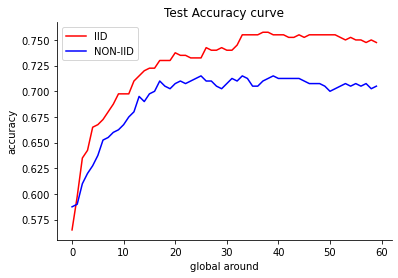

<Figure size 432x288 with 0 Axes>

In [ ]:
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('global around')
plt.ylabel('accuracy')
# plt.plot(epochs,Adam_test,'b', label='Adam')
plt.plot([i for i in range(60)],IID_accu,'r', label='IID')
plt.plot([i for i in range(60)],NIID_accu,'b', label='NON-IID')
# plt.plot(epochs,test_task3,'b', label='task3 acc')
plt.legend()
plt.title('Test Accuracy curve')
plt.figure()

<Figure size 432x288 with 0 Axes>

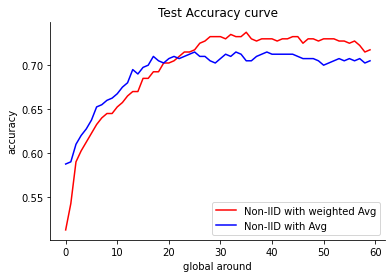

<Figure size 432x288 with 0 Axes>

In [ ]:
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('global around')
plt.ylabel('accuracy')
# plt.plot(epochs,Adam_test,'b', label='Adam')
plt.plot([i for i in range(60)],NIID_w_accu,'r', label='Non-IID with weighted Avg')
plt.plot([i for i in range(60)],NIID_accu,'b', label='Non-IID with Avg')
# plt.plot(epochs,test_task3,'b', label='task3 acc')
plt.legend()
plt.title('Test Accuracy curve')
plt.figure()